## Data Load

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (replace 'path/underwater_network_data_v3.csv' with your actual path)
df = pd.read_csv("path/underwater_network_data_v3.csv")

print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Node ID                         1000 non-null   int64  
 1   X                               1000 non-null   float64
 2   Y                               1000 non-null   float64
 3   Z                               1000 non-null   float64
 4   Node Density                    1000 non-null   float64
 5   Communication Range (m)         1000 non-null   float64
 6   Transmission Power (dB)         1000 non-null   float64
 7   Signal Attenuation (dB/m)       1000 non-null   float64
 8   Noise Level (dB)                1000 non-null   float64
 9   Mobility (m/s)                  1000 non-null   float64
 10  Salinity (PSU)                  1000 non-null   float64
 11  Temperature (°C)                1000 non-null   float64
 12  Ocean Current Speed (m/s)       100

---

## Data Preprocessing

### Removing Outliners

In [190]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in df.columns:
    if df[col].dtype != 'object': 
        df = remove_outliers(df, col)

### Exploratory Data Analysis (EDA) with Matplotlib

#### Transmission Power

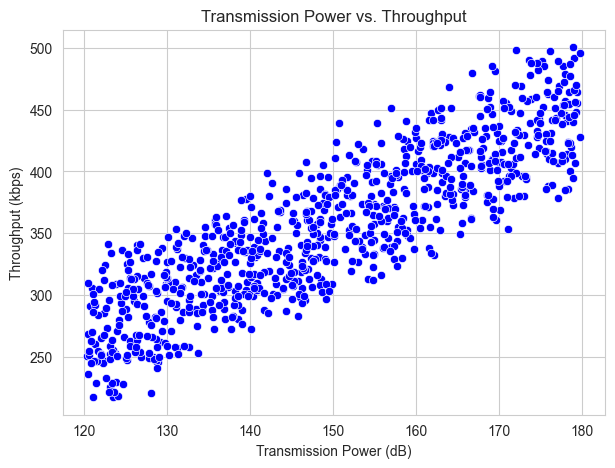

In [191]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["Transmission Power (dB)"], y=df["Throughput (kbps)"], color="blue")
plt.title("Transmission Power vs. Throughput")
plt.xlabel("Transmission Power (dB)")
plt.ylabel("Throughput (kbps)")
plt.show()

#### Signal Attenuation

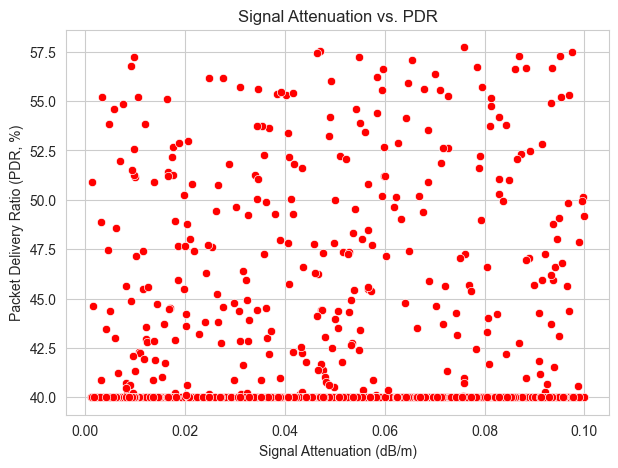

In [192]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["Signal Attenuation (dB/m)"], y=df["Packet Delivery Ratio (PDR, %)"], color="red")
plt.title("Signal Attenuation vs. PDR")
plt.xlabel("Signal Attenuation (dB/m)")
plt.ylabel("Packet Delivery Ratio (PDR, %)")
plt.show()

#### Mobility 

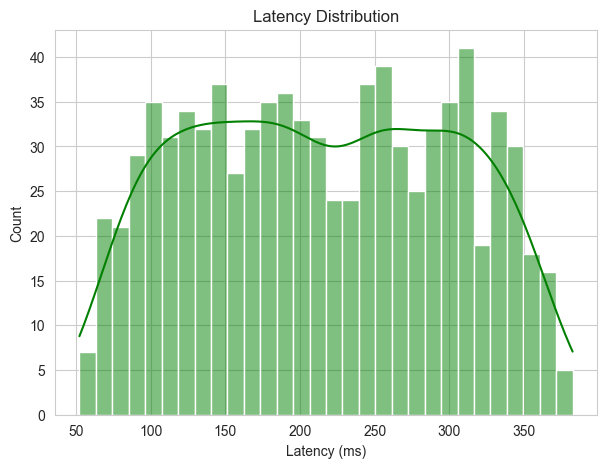

In [193]:
plt.figure(figsize=(7,5))
sns.histplot(df["Latency (ms)"], bins=30, kde=True, color="green")
plt.title("Latency Distribution")
plt.xlabel("Latency (ms)")
plt.show()

##### Removing non-numeric columns 

In [ ]:
df_numeric = df.drop(columns=["Node ID", "Neighbors"]) 

# Convert data to float (in case some values were read as strings)
df_numeric = df_numeric.apply(pd.to_numeric, errors="coerce")

#### Correlation Heatmap

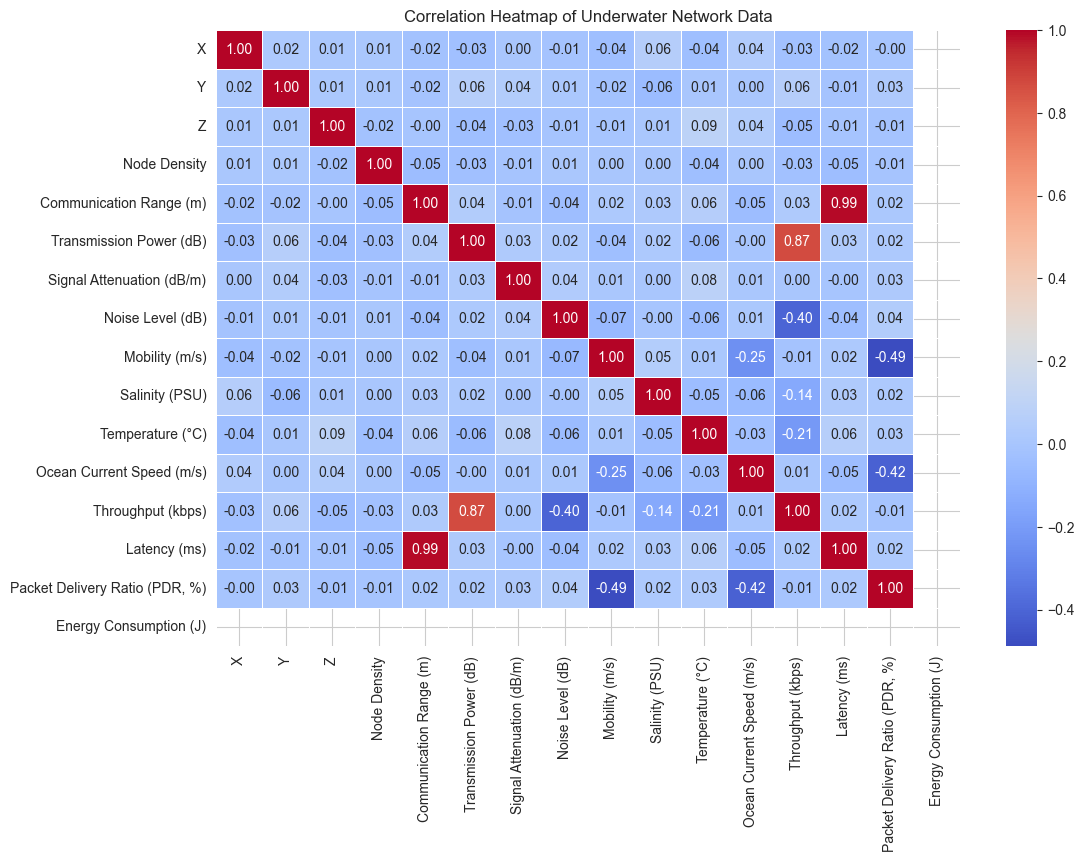

In [195]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Underwater Network Data")
plt.show()

---

### Model Training

Model training using machine learning to predict key performance metrics such as Throughput, Latency, PDR, and Energy Consumption

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = df_numeric.drop(columns=["Throughput (kbps)", "Latency (ms)", "Packet Delivery Ratio (PDR, %)", "Energy Consumption (J)"])
targets = df_numeric[["Throughput (kbps)", "Latency (ms)", "Packet Delivery Ratio (PDR, %)", "Energy Consumption (J)"]]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {}
predictions = {}
metrics = {}

for col in targets.columns:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train[col])
    y_pred = model.predict(X_test_scaled)
    
    models[col] = model
    predictions[col] = y_pred

    metrics[col] = {
        "MAE": mean_absolute_error(y_test[col], y_pred),
        "MSE": mean_squared_error(y_test[col], y_pred),
        "R2 Score": r2_score(y_test[col], y_pred)
    }

metrics


{'Throughput (kbps)': {'MAE': 8.586867453335614,
  'MSE': 119.15956295785956,
  'R2 Score': 0.9672837095799433},
 'Latency (ms)': {'MAE': 11.389079600512947,
  'MSE': 178.66579690748148,
  'R2 Score': 0.9750437703260281},
 'Packet Delivery Ratio (PDR, %)': {'MAE': 0.6086412155050572,
  'MSE': 1.0085973040822707,
  'R2 Score': 0.9893254136985289},
 'Energy Consumption (J)': {'MAE': 0.0, 'MSE': 0.0, 'R2 Score': 1.0}}

#### Observations from Distributions

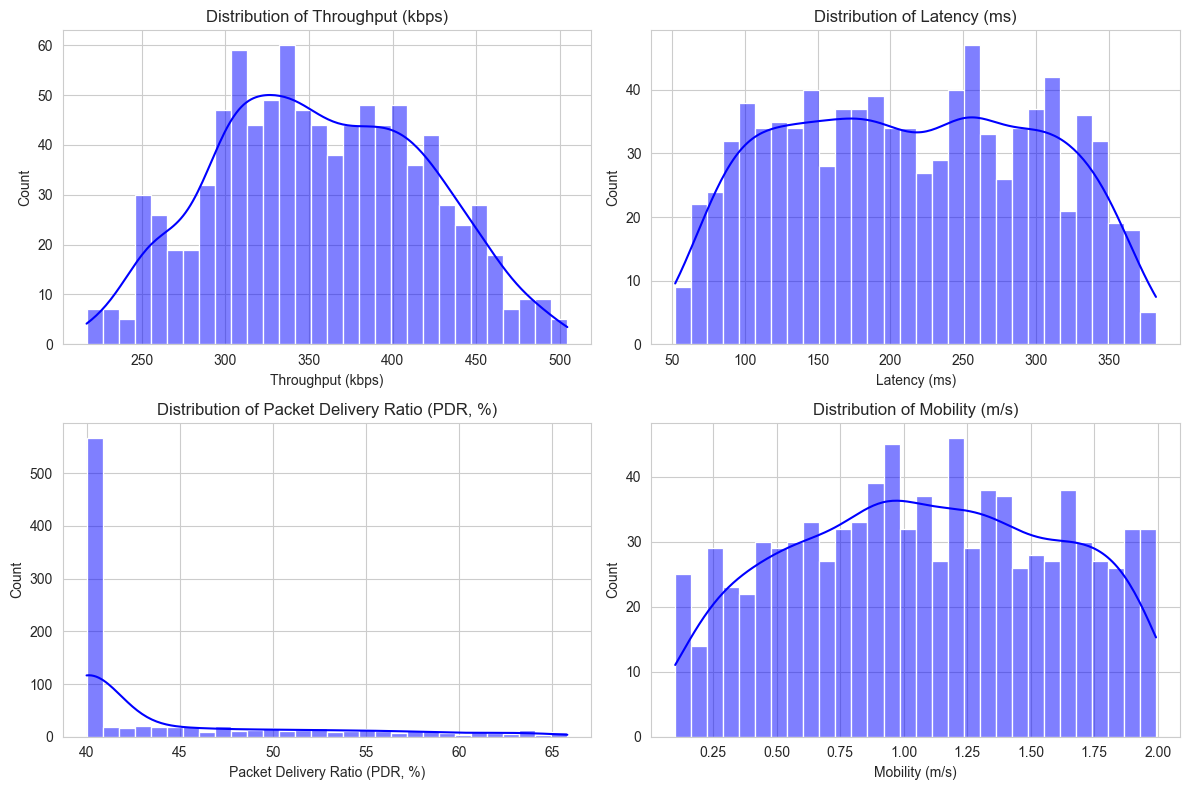

In [ ]:
features_to_plot = ["Throughput (kbps)", "Latency (ms)", "Packet Delivery Ratio (PDR, %)", "Mobility (m/s)"]
plt.figure(figsize=(12, 8))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=30, kde=True, color="blue")
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


<ol>Packet Delivery Ratio (PDR)
<li>Skewed towards lower values (mostly below 50%).<li>High frequency around 40% suggests a potential cap in the dataset.
<ol>

<ul>Energy Consumption
<li>Appears constant at 200J → This makes it useless for modeling as there is no variation.<ul>

---

In [101]:
import numpy as np

# Check unique values in PDR and Energy Consumption to verify constraints
pdr_unique = df_numeric["Packet Delivery Ratio (PDR, %)"].unique()
energy_unique = df_numeric["Energy Consumption (J)"].unique()

# Compute basic statistics to check for anomalies
pdr_stats = df_numeric["Packet Delivery Ratio (PDR, %)"].describe()
energy_stats = df_numeric["Energy Consumption (J)"].describe()

pdr_unique, energy_unique, pdr_stats, energy_stats


(array([40.        , 42.88829484, 52.34602689, 51.41393513, 66.58799138,
        60.86908172, 43.38112137, 42.27851448, 51.16189402, 50.91986168,
        42.2523078 , 52.86278123, 49.8876775 , 52.24362166, 46.31051176,
        43.69443887, 40.87270417, 42.24366733, 44.64311379, 47.26164549,
        45.48886835, 65.56803065, 70.57291019, 80.03164992, 69.9823579 ,
        47.79843095, 41.38160191, 50.98787201, 67.11407914, 40.85716654,
        84.33997909, 56.00639778, 51.28214193, 49.10170429, 46.23856853,
        47.44106873, 42.38640996, 58.29564161, 61.77204791, 55.33628641,
        50.76305716, 61.07369469, 51.07302392, 48.5599921 , 65.82824438,
        47.67534578, 40.5183254 , 58.22379214, 47.88098271, 42.76284321,
        42.97144155, 61.12636763, 69.28155981, 51.6059521 , 41.79677556,
        40.98369267, 76.07306495, 49.27702489, 44.43242136, 41.94137259,
        52.67474733, 47.36451744, 54.40663422, 62.15191626, 60.44762527,
        55.2804326 , 62.91051283, 49.45503735, 42.5

In [102]:
# Compute correlation matrix to analyze relationships
correlation_matrix = df_numeric.corr()

# Extract correlations of PDR and Energy Consumption with other variables
pdr_correlations = correlation_matrix["Packet Delivery Ratio (PDR, %)"].sort_values(ascending=False)
energy_correlations = correlation_matrix["Energy Consumption (J)"].sort_values(ascending=False)

pdr_correlations, energy_correlations


(Packet Delivery Ratio (PDR, %)    1.000000
 Salinity (PSU)                    0.061700
 Transmission Power (dB)           0.034373
 X                                 0.020483
 Noise Level (dB)                  0.019984
 Signal Attenuation (dB/m)         0.014150
 Throughput (kbps)                 0.011153
 Temperature (°C)                  0.011025
 Communication Range (m)          -0.012194
 Latency (ms)                     -0.013113
 Z                                -0.018137
 Y                                -0.019326
 Node Density                     -0.049992
 Ocean Current Speed (m/s)        -0.579425
 Mobility (m/s)                   -0.604335
 Energy Consumption (J)                 NaN
 Name: Packet Delivery Ratio (PDR, %), dtype: float64,
 X                                NaN
 Y                                NaN
 Z                                NaN
 Node Density                     NaN
 Communication Range (m)          NaN
 Transmission Power (dB)          NaN
 Signal Atten

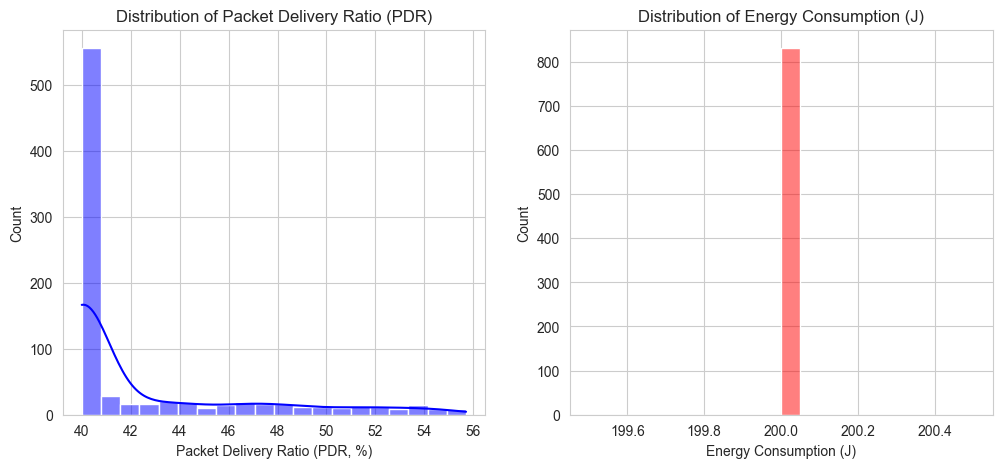

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_style("whitegrid")

# Create subplots for PDR and Energy Consumption distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PDR distribution
sns.histplot(df["Packet Delivery Ratio (PDR, %)"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Packet Delivery Ratio (PDR)")

# Plot Energy Consumption distribution
sns.histplot(df["Energy Consumption (J)"], bins=20, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Energy Consumption (J)")

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = df_numeric.drop(columns=["Energy Consumption (J)"])

features = df_numeric.drop(columns=["Throughput (kbps)", "Latency (ms)", "Packet Delivery Ratio (PDR, %)"])
targets = df_numeric[["Throughput (kbps)", "Latency (ms)", "Packet Delivery Ratio (PDR, %)"]]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "R² Score": r2_score(y_test, y_pred)
    }
    
    results[name] = metrics

import pprint
pprint.pprint(results)


c:\Users\kakol\miniconda3\envs\my_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kakol\miniconda3\envs\my_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'Linear Regression': {'MAE': 5.904082756216199,
                       'RMSE': 7.012067632906167,
                       'R² Score': 0.8761374353778709},
 'Random Forest': {'MAE': 11.324815968321133,
                   'RMSE': 14.003921197037478,
                   'R² Score': 0.6914522675918079},
 'XGBoost': {'MAE': 5.925932680701066,
             'RMSE': 7.211543225362374,
             'R² Score': 0.9835242629051208}}


c:\Users\kakol\miniconda3\envs\my_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*Conclusion: Best model is XGBOOST*.
It captures most of the variability in the data.


#### 

---

### Analysis

##### Feature importances from the best model (XGBoost)

C:\Users\kakol\AppData\Local\Temp\ipykernel_25892\177773443.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


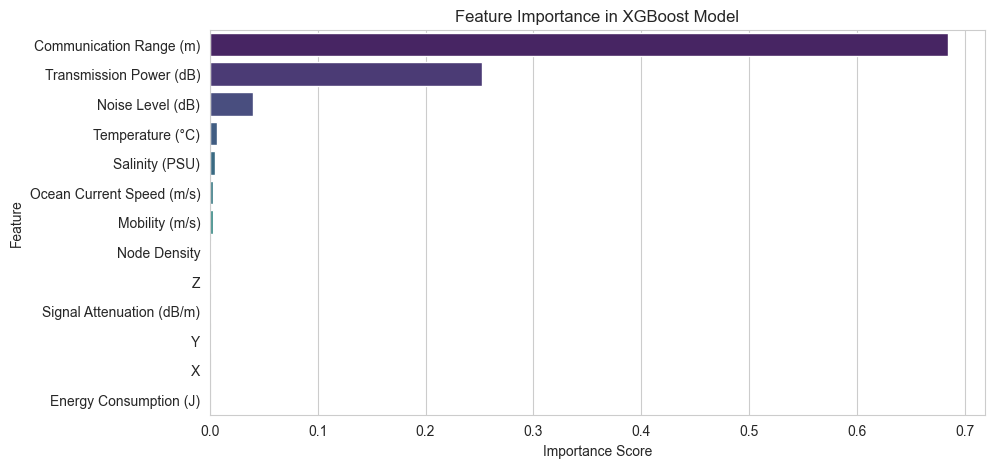

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best model (XGBoost)
xgb_feature_importance = models["XGBoost"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": features.columns,
    "Importance": xgb_feature_importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Feature Importance in XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


#### Classify network conditions as Efficient vs. Inefficient based on Throughput, PDR, and Latency.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define efficiency criteria based on dataset statistics
throughput_threshold = df_numeric["Throughput (kbps)"].median()
pdr_threshold = df_numeric["Packet Delivery Ratio (PDR, %)"].median()
latency_threshold = df_numeric["Latency (ms)"].median()

# Label data as Efficient (1) or Inefficient (0)
df_numeric["Efficiency_Label"] = ((df_numeric["Throughput (kbps)"] > throughput_threshold) & 
                          (df_numeric["Packet Delivery Ratio (PDR, %)"] > pdr_threshold) & 
                          (df_numeric["Latency (ms)"] < latency_threshold)).astype(int)

# Select features for classification
classification_features = ["Communication Range (m)", "Transmission Power (dB)", "Noise Level (dB)", 
                           "Temperature (°C)", "Salinity (PSU)"]

X = df_numeric[classification_features]
y = df_numeric["Efficiency_Label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8500
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       172
           1       0.43      0.21      0.29        28

    accuracy                           0.85       200
   macro avg       0.66      0.58      0.60       200
weighted avg       0.82      0.85      0.83       200

Confusion Matrix:
 [[164   8]
 [ 22   6]]


In [210]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

In [217]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



c:\Users\kakol\miniconda3\envs\my_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8596491228070176
Confusion Matrix:
 [[141  16]
 [  8   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       157
           1       0.27      0.43      0.33        14

    accuracy                           0.86       171
   macro avg       0.61      0.66      0.63       171
weighted avg       0.89      0.86      0.87       171



#### Clustering Analysis (Grouping Nodes by Performance)

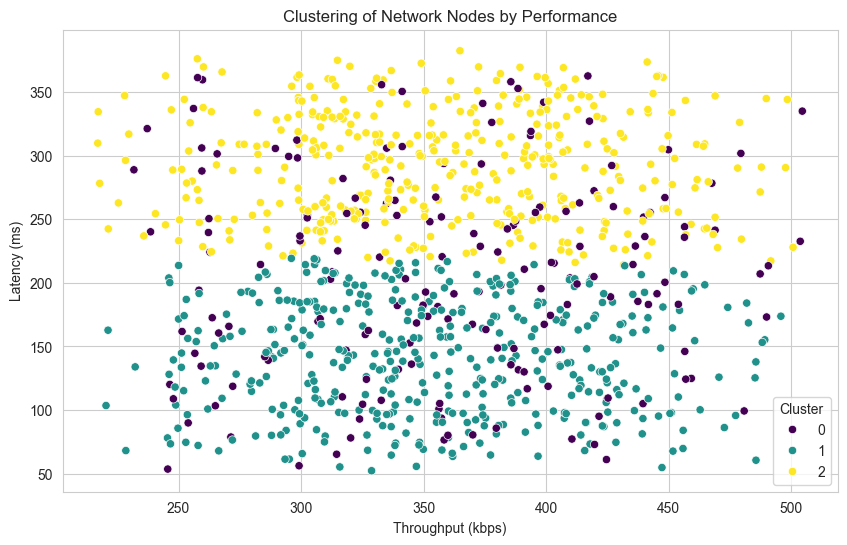

,Throughput (kbps),"Packet Delivery Ratio (PDR, %)",Latency (ms)
Cluster,,,
0,360.436316,66.783968,206.262598
1,354.177494,42.180131,140.746977
2,358.154132,42.791302,292.583182


In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Select key performance metrics for clustering
clustering_features = df_numeric[["Throughput (kbps)", "Packet Delivery Ratio (PDR, %)", "Latency (ms)"]]

# Standardize data
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

# Apply K-Means clustering (using 3 clusters: Low, Medium, High performance)    2
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_numeric["Cluster"] = kmeans.fit_predict(clustering_features_scaled)

# Visualize Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_numeric["Throughput (kbps)"], y=df_numeric["Latency (ms)"], hue=df_numeric["Cluster"], palette="viridis")
plt.title("Clustering of Network Nodes by Performance")
plt.xlabel("Throughput (kbps)")
plt.ylabel("Latency (ms)")
plt.legend(title="Cluster")
plt.show()

# Print cluster statistics
df_numeric.groupby("Cluster")[["Throughput (kbps)", "Packet Delivery Ratio (PDR, %)", "Latency (ms)"]].mean()


Cluster 0 (Purple - Medium Performance): Best balance of throughput, PDR, and latency. Reduce latency for real-time applications

Cluster 1 (Teal - Efficient Networks): Best for low-latency applications. Improve PDR by enhancing signal strength or using better routing algorithms

Cluster 2 (Yellow - Inefficient Networks): Least efficient, likely suffering from congestion or weak links. Needs significant improvements, possibly through better topology design or error correction mechanisms

## VISUALISATION

### Topology Visualisation

#### 3D Network Visualization Based on Throughput

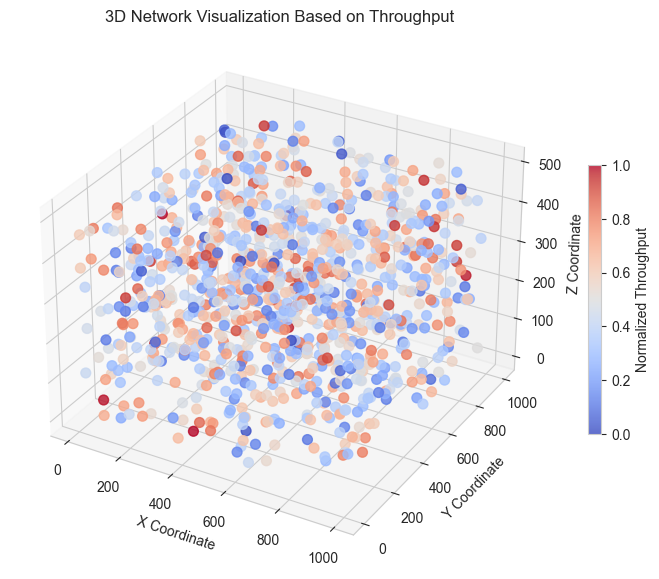

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

# Extract necessary features
X = df_numeric['X']
Y = df_numeric['Y']
Z = df_numeric['Z']
throughput = df_numeric['Throughput (kbps)']
latency = df_numeric['Latency (ms)']
cluster_labels = df_numeric['Cluster'] if 'Cluster' in df_numeric.columns else None

# Normalize throughput for coloring
scaler = MinMaxScaler()
thr_scaled = scaler.fit_transform(throughput.values.reshape(-1, 1)).flatten()

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes with color based on throughput
sc = ax.scatter(X, Y, Z, c=thr_scaled, cmap='coolwarm', s=50, alpha=0.8)

# Color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("Normalized Throughput")

# Labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Network Visualization Based on Throughput")

plt.show()


#### 3D Network Visualization with Connectivity

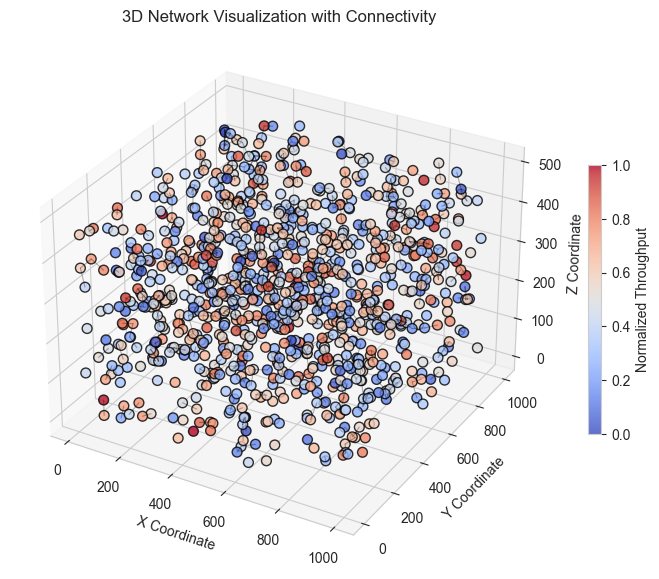

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# Extract necessary features
X = df_numeric['X']
Y = df_numeric['Y']
Z = df_numeric['Z']
throughput = df_numeric['Throughput (kbps)']
latency = df_numeric['Latency (ms)']
cluster_labels = df_numeric['Cluster'] if 'Cluster' in df_numeric.columns else None

# Normalize throughput for coloring
scaler = MinMaxScaler()
thr_scaled = scaler.fit_transform(throughput.values.reshape(-1, 1)).flatten()

# Define communication range (adjustable parameter)
COMM_RANGE = 50

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes with color based on throughput
sc = ax.scatter(X, Y, Z, c=thr_scaled, cmap='coolwarm', s=50, alpha=0.8, edgecolors='k')

# Add edges based on distance threshold
for i in range(len(df_numeric)):
    for j in range(i + 1, len(df_numeric)):
        dist = np.sqrt((X[i] - X[j])**2 + (Y[i] - Y[j])**2 + (Z[i] - Z[j])**2)
        if dist < COMM_RANGE:
            ax.plot([X[i], X[j]], [Y[i], Y[j]], [Z[i], Z[j]], c='black', alpha=0.3, linewidth=0.8)

# Color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("Normalized Throughput")

# Labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Network Visualization with Connectivity")

plt.show()


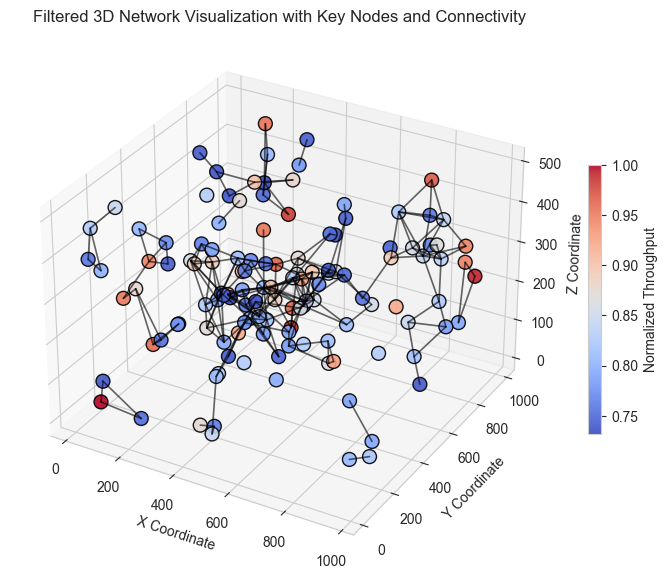

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Extract necessary features
X = df_numeric['X']
Y = df_numeric['Y']
Z = df_numeric['Z']
throughput = df_numeric['Throughput (kbps)']
latency = df_numeric['Latency (ms)']
cluster_labels = df_numeric['Cluster'] if 'Cluster' in df_numeric.columns else None

scaler = MinMaxScaler()
thr_scaled = scaler.fit_transform(throughput.values.reshape(-1, 1)).flatten()

# Define communication range
COMM_RANGE = 150

# Select important nodes: highest throughput or clustered
important_threshold = np.percentile(throughput, 85)  # Top 15% throughput
important_nodes = throughput >= important_threshold

# Filtered node coordinates
X_imp, Y_imp, Z_imp = X[important_nodes], Y[important_nodes], Z[important_nodes]
thr_scaled_imp = thr_scaled[important_nodes]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot only important nodes
sc = ax.scatter(X_imp, Y_imp, Z_imp, c=thr_scaled_imp, cmap='coolwarm', s=100, alpha=0.9, edgecolors='k')

# Add edges only for important nodes
for i in range(len(X_imp)):
    for j in range(i + 1, len(X_imp)):
        dist = np.sqrt((X_imp.iloc[i] - X_imp.iloc[j])**2 + (Y_imp.iloc[i] - Y_imp.iloc[j])**2 + (Z_imp.iloc[i] - Z_imp.iloc[j])**2)
        if dist < COMM_RANGE:
            ax.plot([X_imp.iloc[i], X_imp.iloc[j]], [Y_imp.iloc[i], Y_imp.iloc[j]], [Z_imp.iloc[i], Z_imp.iloc[j]], 
                    c='black', alpha=0.6, linewidth=1.2)

cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("Normalized Throughput")

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Filtered 3D Network Visualization with Key Nodes and Connectivity")

plt.show()


### Signal Propagation and Attenuation


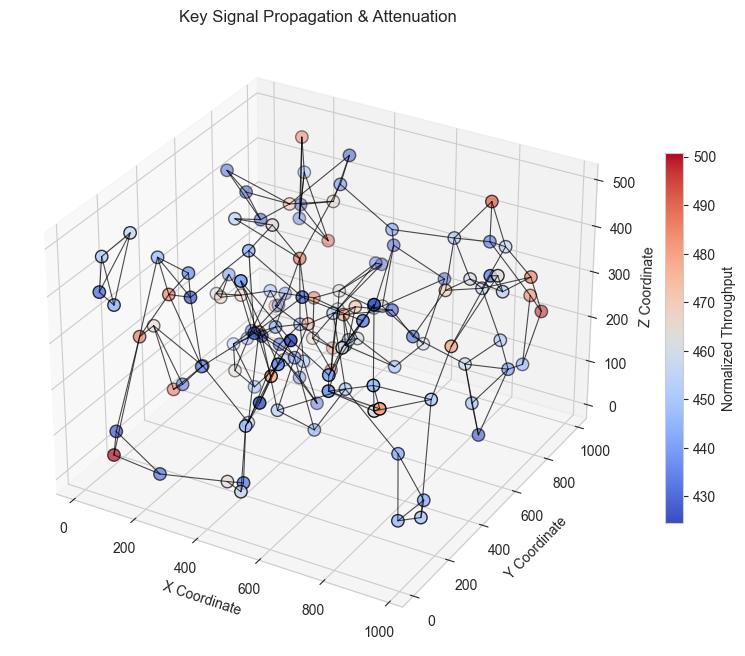

In [ ]:
x, y, z = df_numeric['X'], df_numeric['Y'], df_numeric['Z']
throughput = df_numeric['Throughput (kbps)']

# Filter nodes based on throughput threshold (only show stronger nodes)
threshold = np.percentile(throughput, 85)
strong_nodes = df_numeric[throughput >= threshold]

G = nx.Graph()

for i, row in strong_nodes.iterrows():
    G.add_node(i, pos=(row['X'], row['Y'], row['Z']), throughput=row['Throughput (kbps)'])

# Add edges - only to the 3 nearest stronger neighbors
for i, row in strong_nodes.iterrows():
    distances = np.linalg.norm(strong_nodes[['X', 'Y', 'Z']].values - np.array([row['X'], row['Y'], row['Z']]), axis=1)
    nearest_neighbors = np.argsort(distances)[1:4] 
    for neighbor in nearest_neighbors:
        G.add_edge(i, strong_nodes.index[neighbor])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

pos = nx.get_node_attributes(G, 'pos')
colors = [nx.get_node_attributes(G, 'throughput')[n] for n in G.nodes()]

scatter = ax.scatter(*zip(*pos.values()), c=colors, cmap='coolwarm', edgecolors='black', s=80)

for edge in G.edges():
    x_vals, y_vals, z_vals = zip(*[pos[edge[0]], pos[edge[1]]])
    ax.plot(x_vals, y_vals, z_vals, color='black', linewidth=0.8, alpha=0.7)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Key Signal Propagation & Attenuation')
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Normalized Throughput')

plt.show()

### Performance Metrics Visualisation


#### Throughput vs. Latency Scatter Plot

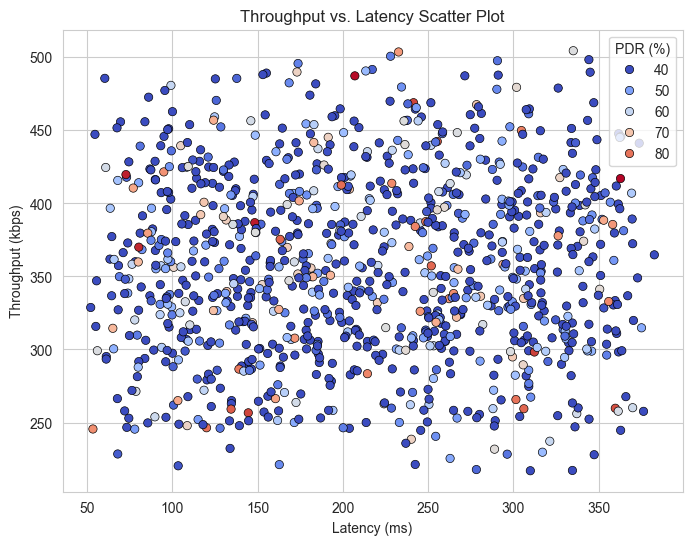

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

df_numeric["Packet Delivery Ratio (PDR, %)"] = pd.to_numeric(df_numeric["Packet Delivery Ratio (PDR, %)"], errors="coerce")

sns.scatterplot(x=df_numeric["Latency (ms)"], y=df_numeric["Throughput (kbps)"], hue=df_numeric["Packet Delivery Ratio (PDR, %)"], 
                palette="coolwarm", edgecolor="black")

plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (kbps)")
plt.title("Throughput vs. Latency Scatter Plot")
plt.legend(title="PDR (%)")
plt.grid(True)
plt.show()



#### Heatmap

##### PDR Heatmap

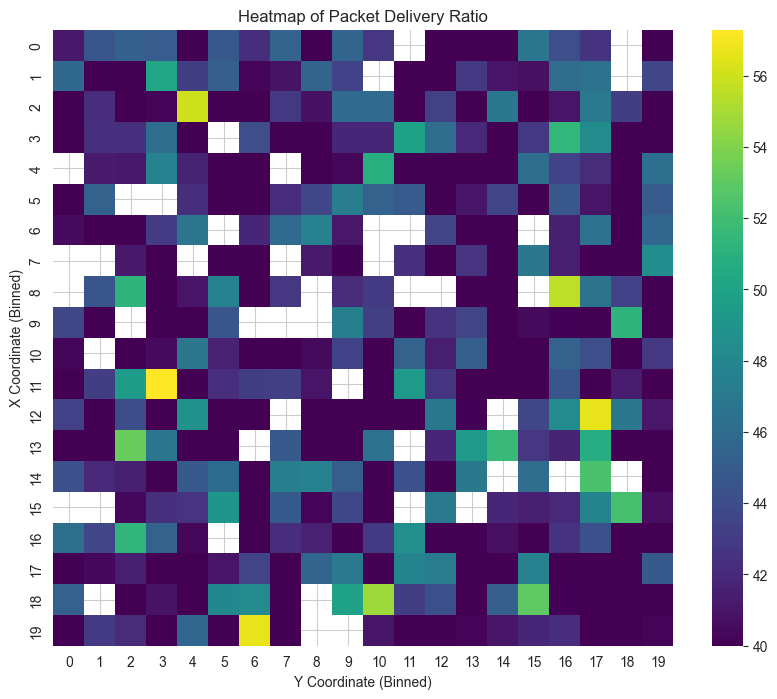

In [197]:
num_bins = 20 
df_numeric['X_bin'] = pd.cut(df_numeric['X'], bins=num_bins, labels=False)
df_numeric['Y_bin'] = pd.cut(df_numeric['Y'], bins=num_bins, labels=False)

heatmap_data = df_numeric.pivot_table(index='X_bin', columns='Y_bin', values='Packet Delivery Ratio (PDR, %)', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis", cbar=True)

plt.title("Heatmap of Packet Delivery Ratio")
plt.xlabel("Y Coordinate (Binned)")
plt.ylabel("X Coordinate (Binned)")
plt.show()


##### Throughput Heatmap

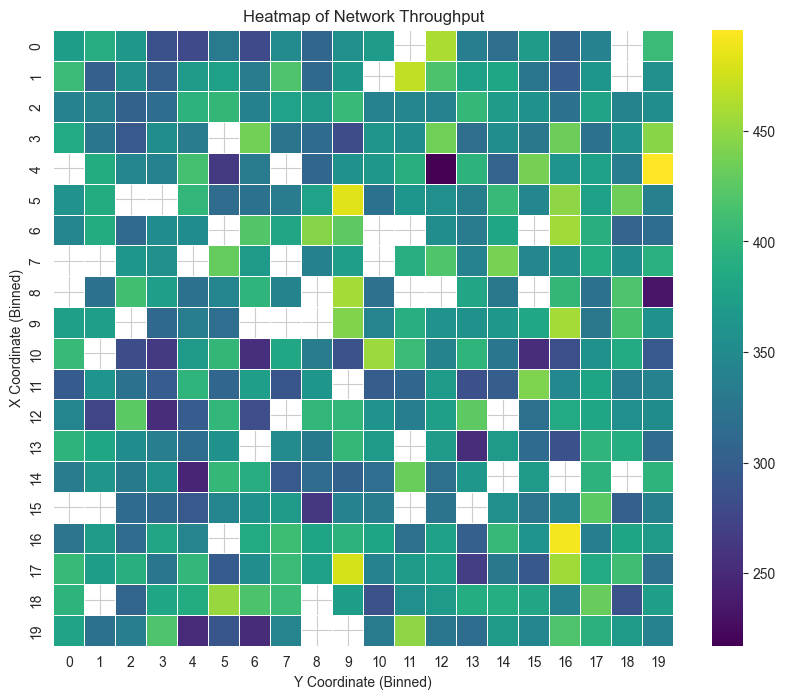

In [198]:
heatmap_data = df_numeric.pivot_table(index='X_bin', columns='Y_bin', values='Throughput (kbps)', aggfunc='mean')

plt.figure(figsize=(10, 8))

sns.heatmap(heatmap_data, cmap='viridis', annot=False, linewidths=0.5)

plt.title("Heatmap of Network Throughput")
plt.xlabel("Y Coordinate (Binned)")
plt.ylabel("X Coordinate (Binned)")

plt.show()

##### Network Latency Heatmap

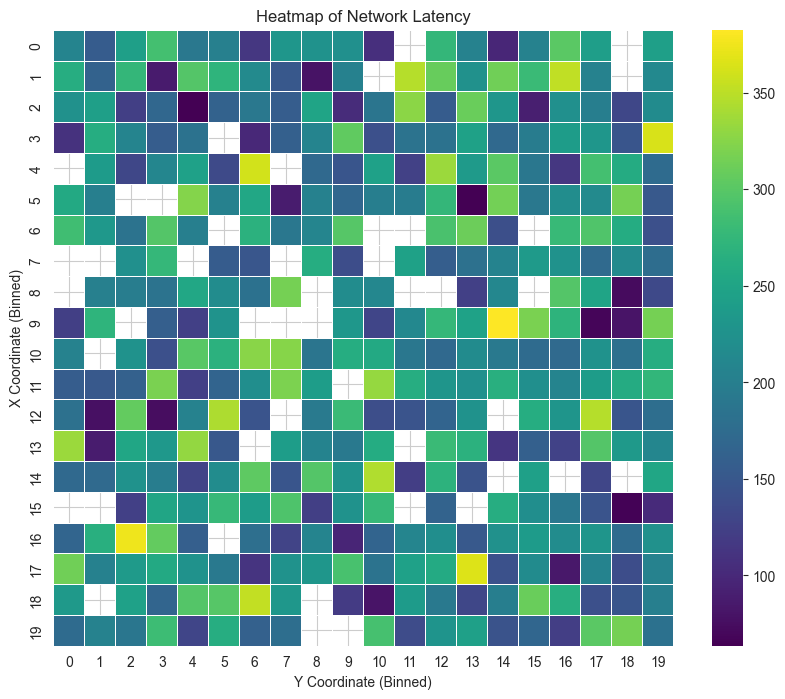

In [199]:
heatmap_data_latency = df_numeric.pivot_table(index='X_bin', columns='Y_bin', values='Latency (ms)', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_latency, cmap='viridis', annot=False, linewidths=0.5)

plt.title("Heatmap of Network Latency")
plt.xlabel("Y Coordinate (Binned)")
plt.ylabel("X Coordinate (Binned)")

plt.show()
